In [1]:
import math

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.contrib.control_flow import scan
from numpyro.infer import SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from pyro.contrib.examples.bart import load_bart_od
from pyro.ops.tensor_utils import periodic_features

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
dataset = load_bart_od()
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

dict_keys(['stations', 'start_date', 'counts'])
torch.Size([78888, 50, 50])
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


In [3]:
T, _, _ = dataset["counts"].shape
data = (
    dataset["counts"][: T // (24 * 7) * 24 * 7].reshape(T // (24 * 7), -1).sum(-1).log()
)
data = data.unsqueeze(-1)
data = jnp.array(data)

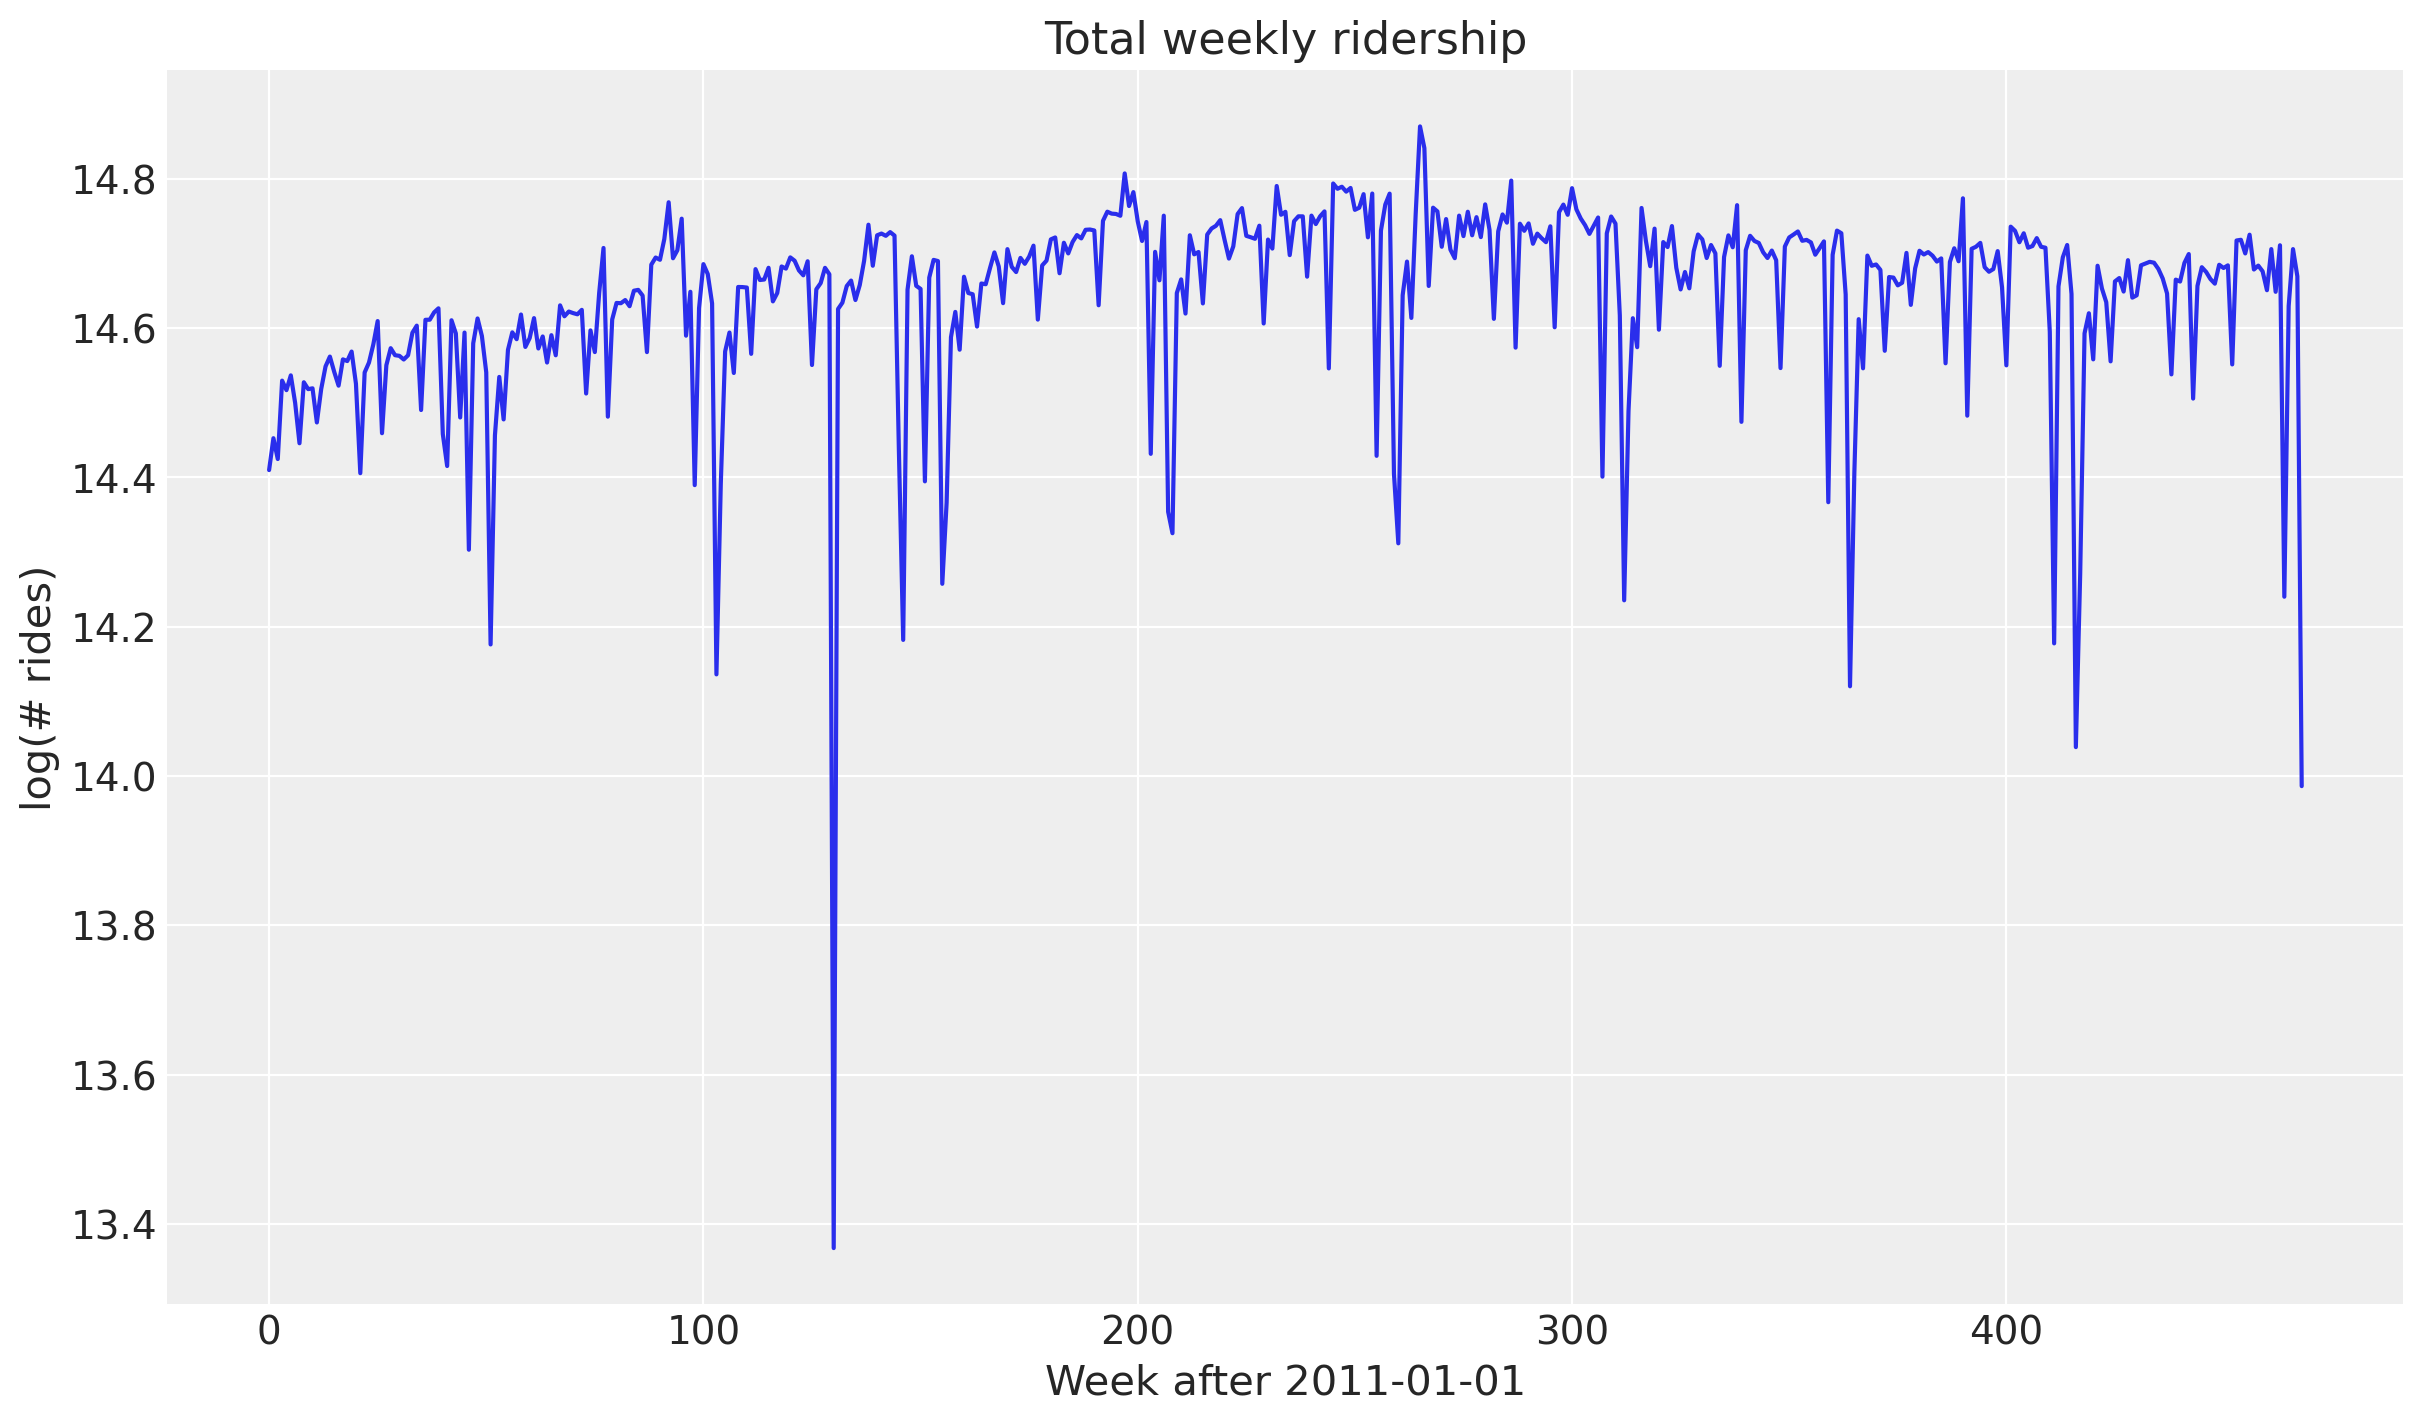

In [4]:
fig, ax = plt.subplots()
ax.plot(data)
ax.set(
    title="Total weekly ridership",
    ylabel="log(# rides)",
    xlabel="Week after 2011-01-01",
);

In [5]:
T0 = 0  # beginning
T2 = data.shape[-2]  # end
T1 = T2 - 52  # train/test split

data_train = data[T0:T1]
data_test = data[T1:T2]

print(f"data_train shape: {data_train.shape}")
print(f"data_test shape: {data_test.shape}")

data_train shape: (417, 1)
data_test shape: (52, 1)


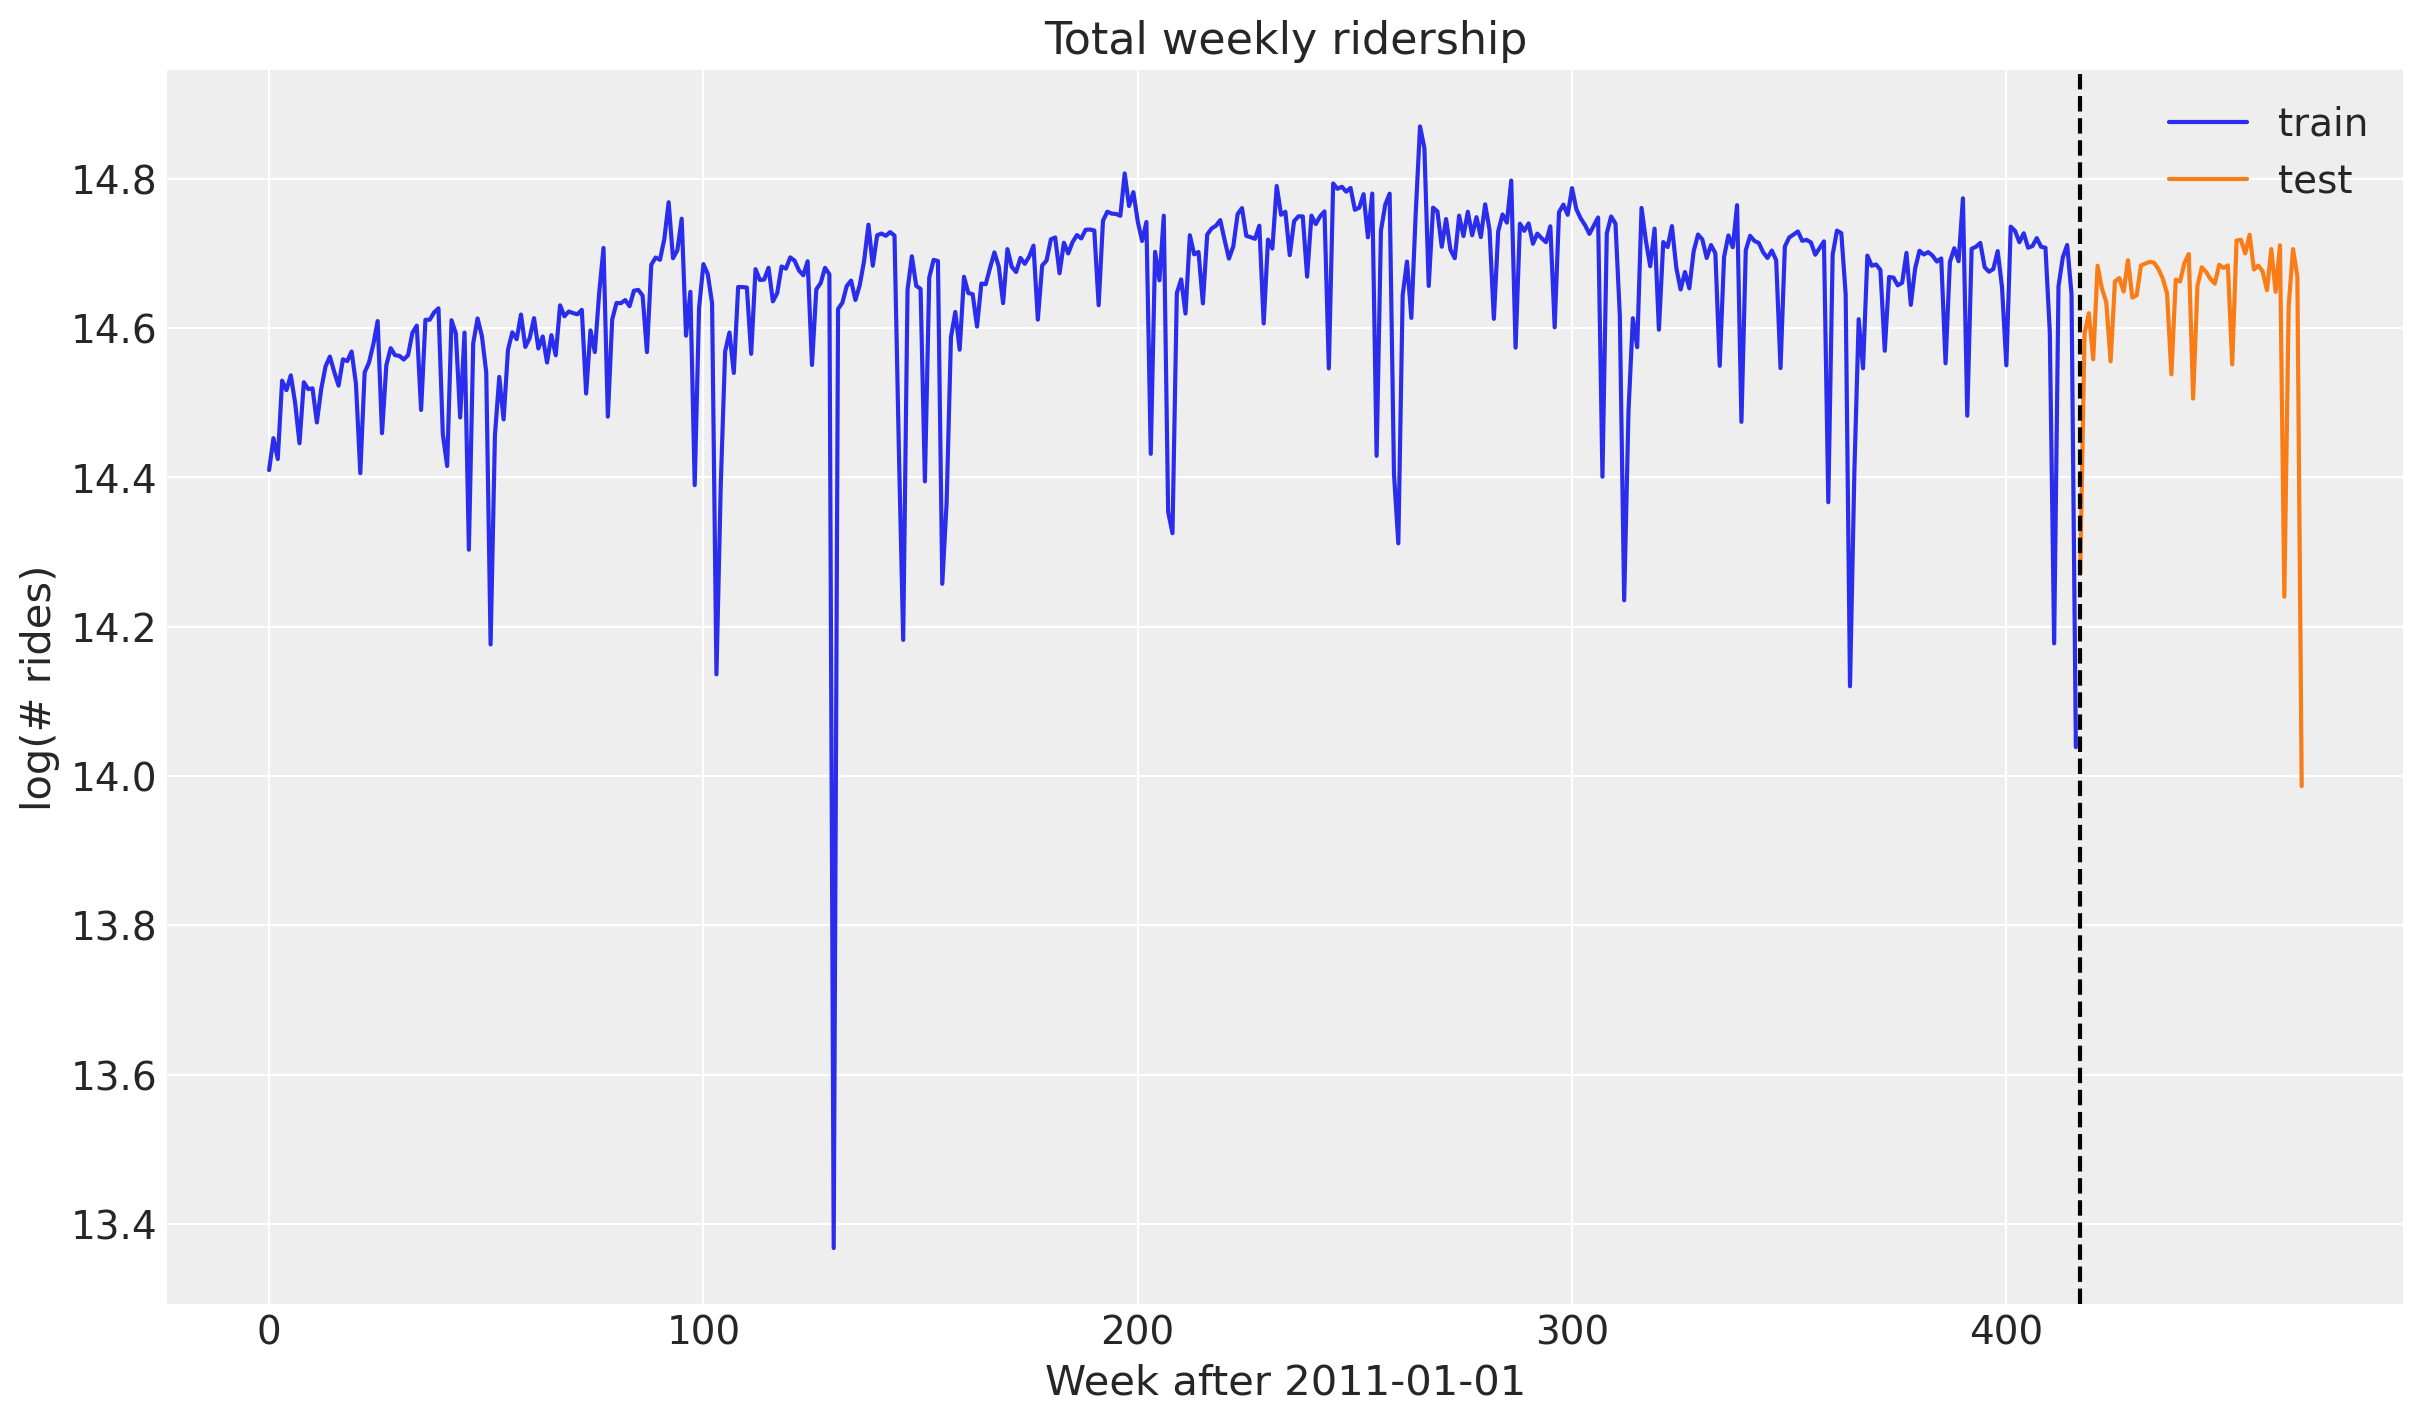

In [6]:
fig, ax = plt.subplots()
ax.plot(jnp.arange(T1), data_train, label="train")
ax.plot(jnp.arange(T1, T2), data_test, label="test")
ax.axvline(T1, c="black", linestyle="--")
ax.legend()
ax.set(
    title="Total weekly ridership",
    ylabel="log(# rides)",
    xlabel="Week after 2011-01-01",
);

In [7]:
fourier_modes_torch = periodic_features(T2, 365.25 / 7)

fourier_modes_torch.shape

torch.Size([469, 52])

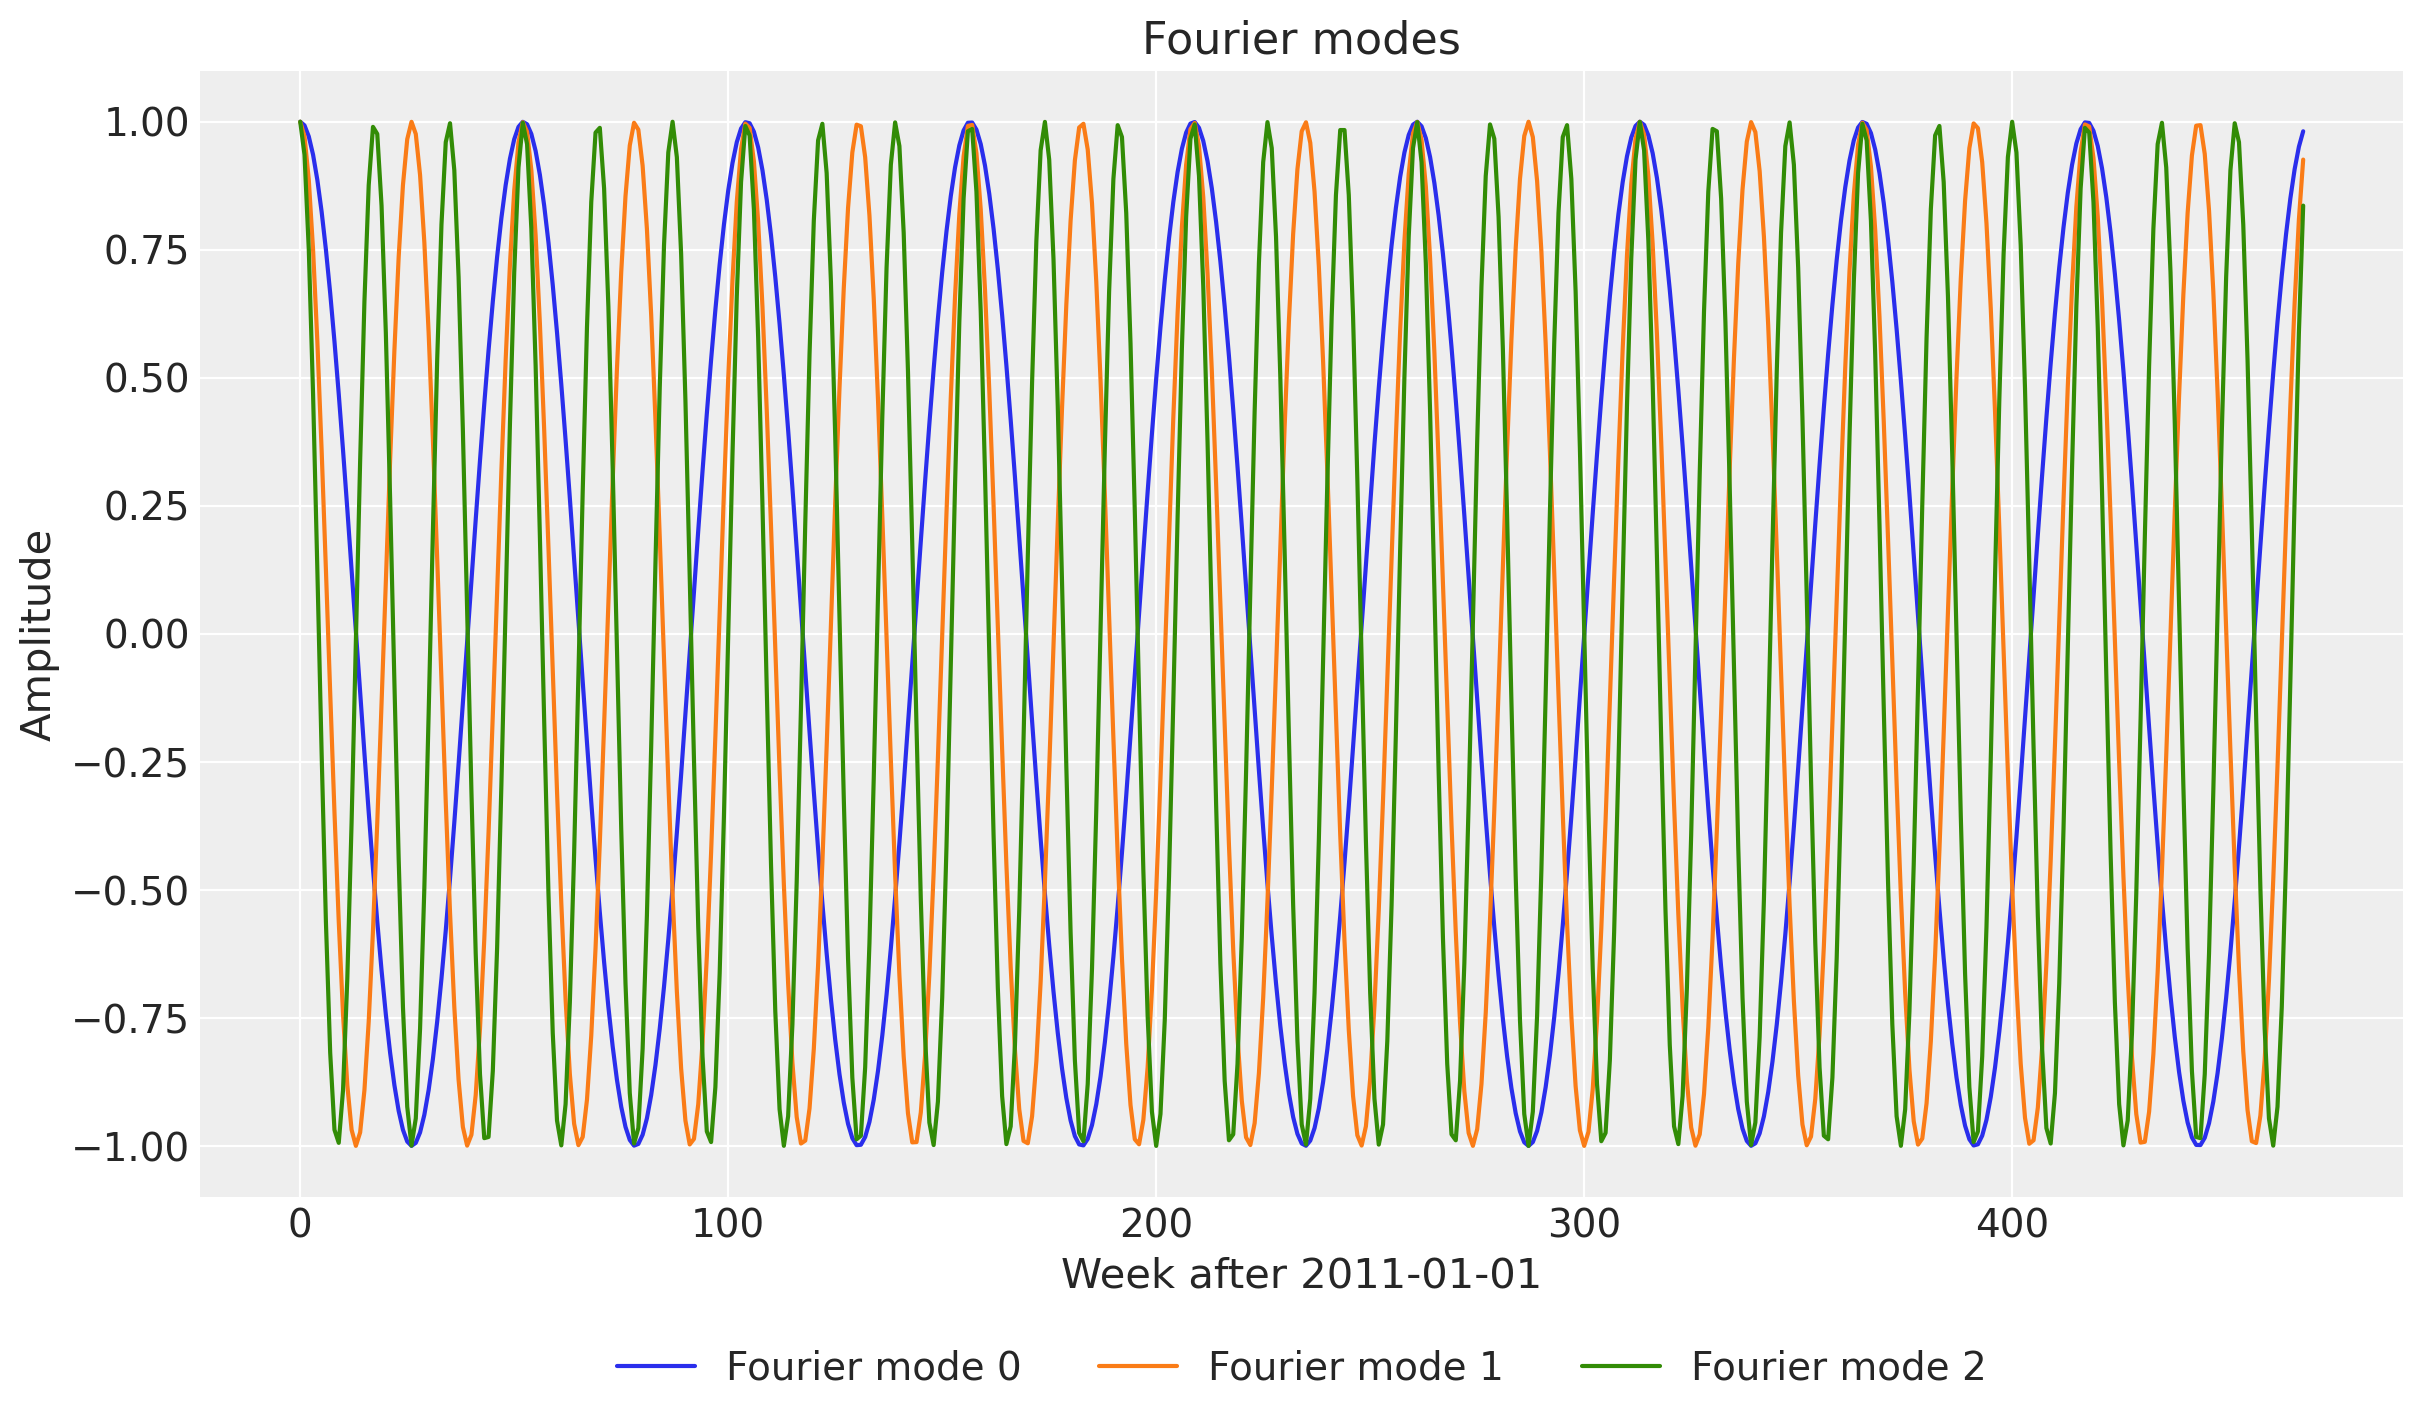

In [8]:
fig, ax = plt.subplots()
for i in range(3):
    ax.plot(fourier_modes_torch[:, i], label=f"Fourier mode {i}")
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=3)
ax.set(
    title="Fourier modes",
    ylabel="Amplitude",
    xlabel="Week after 2011-01-01",
);

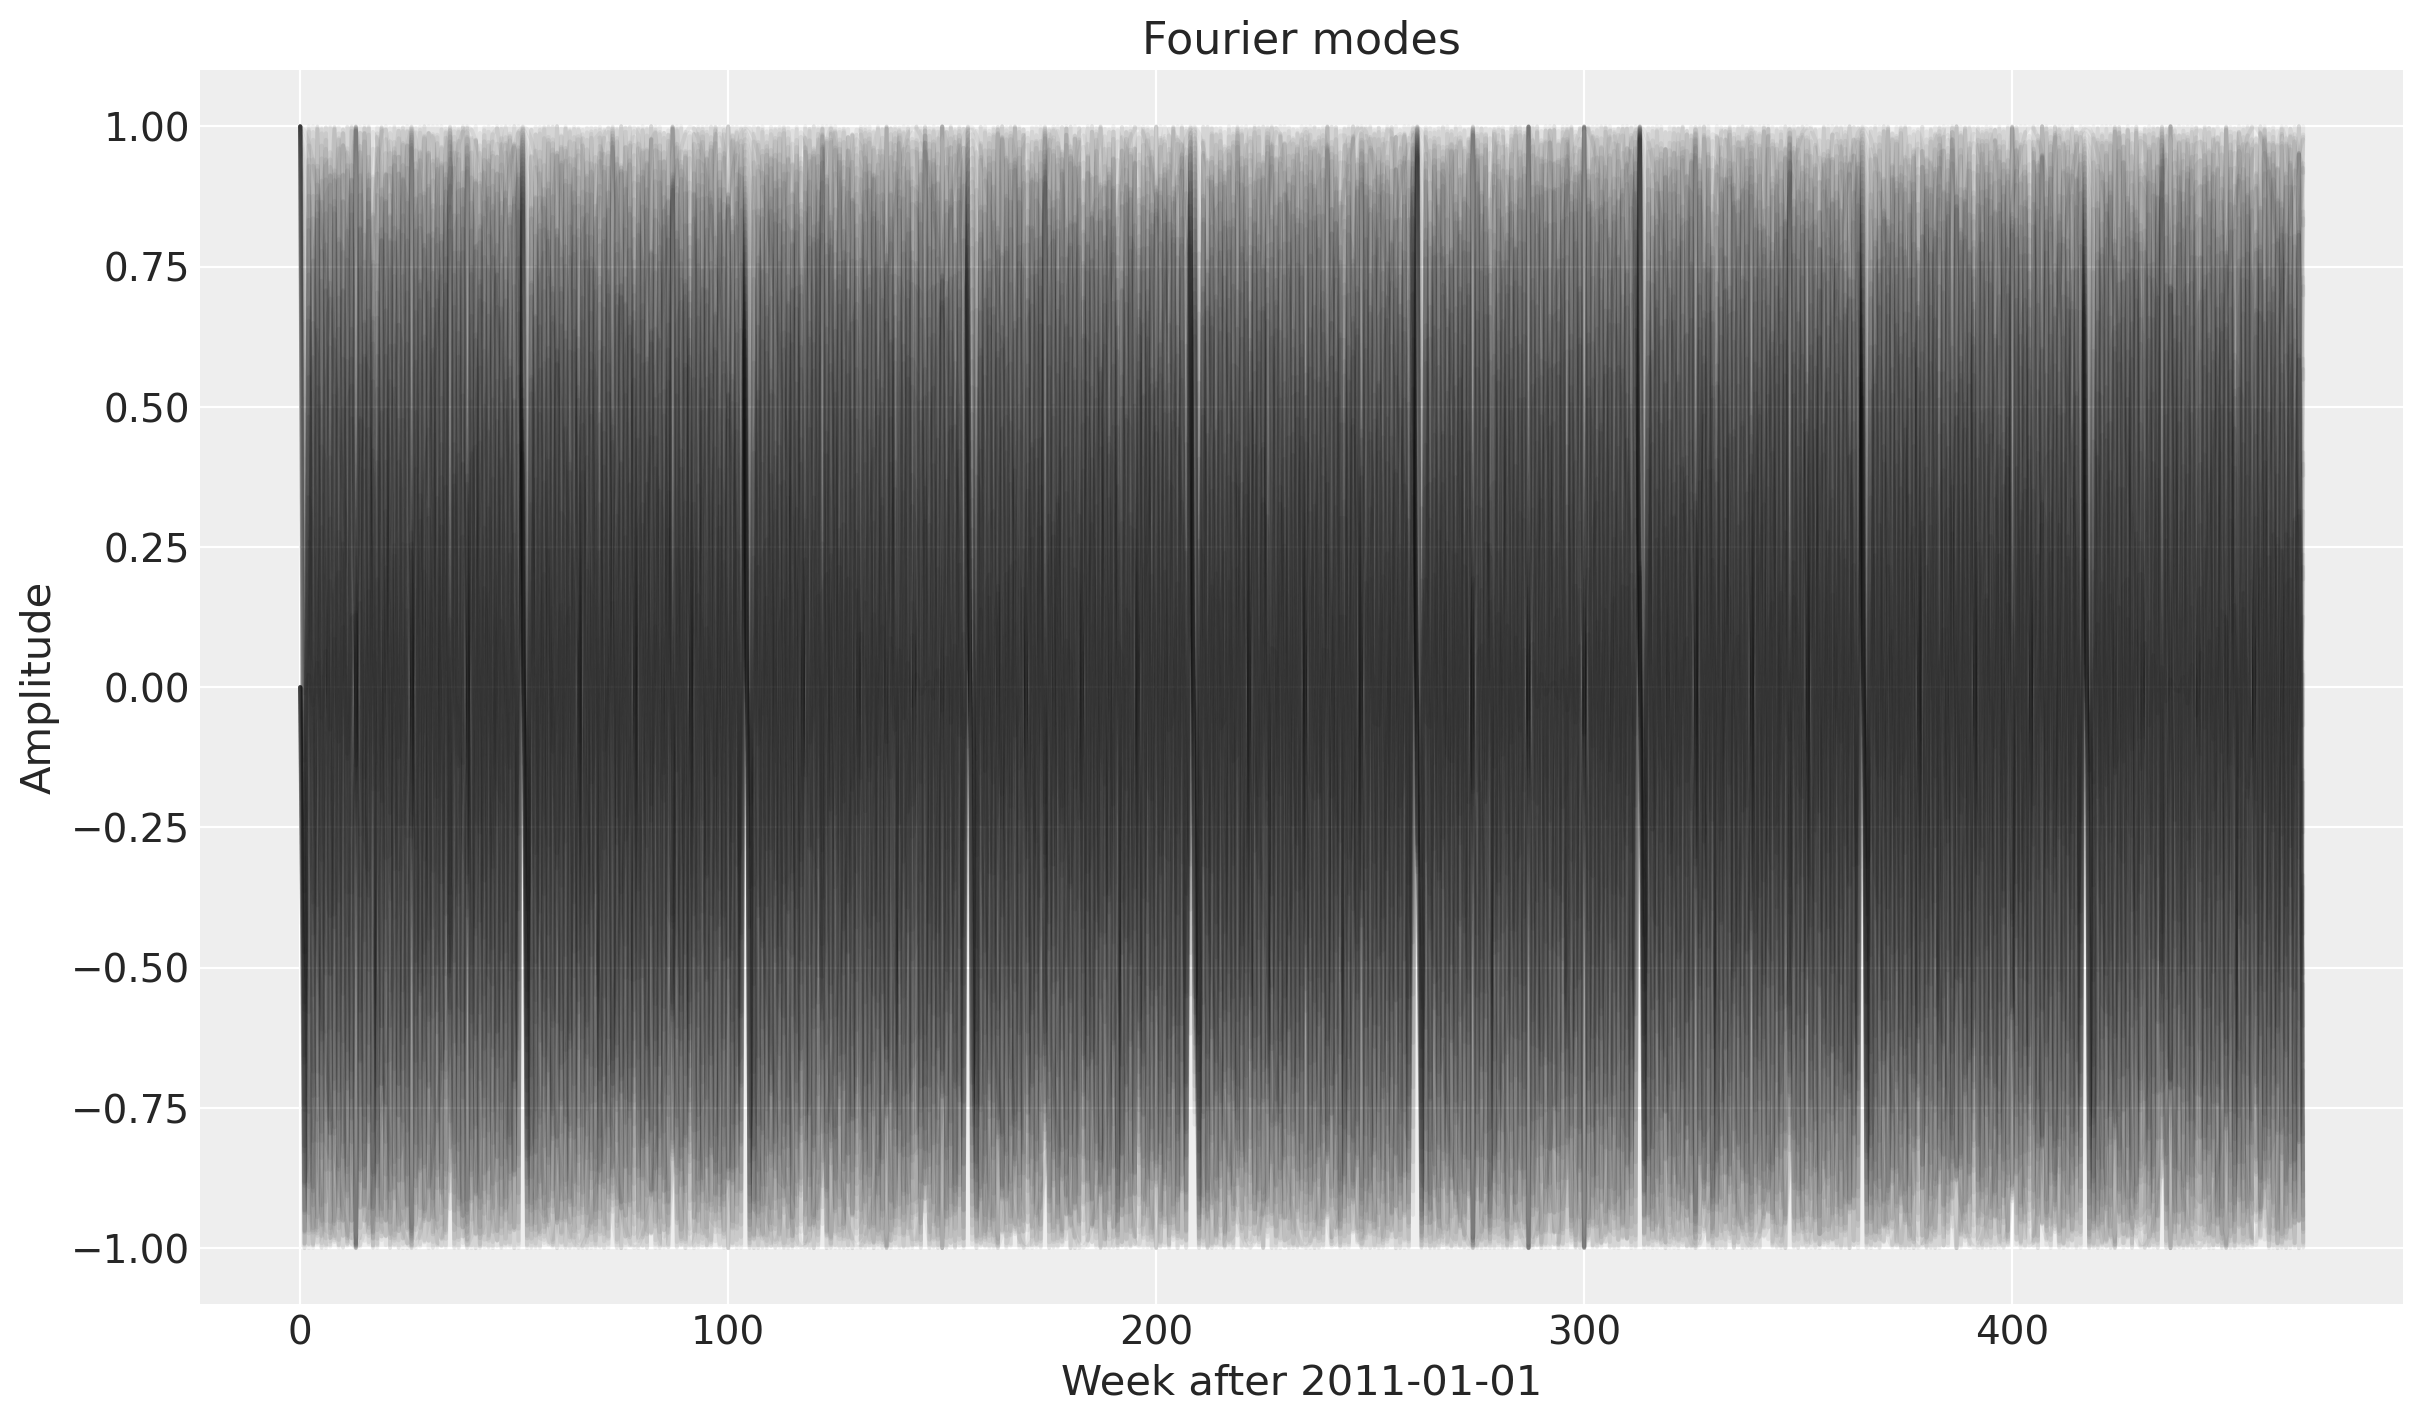

In [9]:
fig, ax = plt.subplots()
ax.plot(fourier_modes_torch, color="black", alpha=0.05)
ax.set(
    title="Fourier modes",
    ylabel="Amplitude",
    xlabel="Week after 2011-01-01",
);

In [10]:
def periodic_features_jax(duration, max_period=None, min_period=None, **options):
    assert isinstance(duration, int) and duration >= 0
    if max_period is None:
        max_period = duration
    if min_period is None:
        min_period = 2
    assert min_period >= 2, "min_period is below Nyquist cutoff"
    assert min_period <= max_period

    t = jnp.arange(float(duration), **options).reshape(-1, 1, 1)
    phase = jnp.array([0, math.pi / 2], **options).reshape(1, -1, 1)
    freq = jnp.arange(1, max_period / min_period, **options).reshape(1, 1, -1) * (
        2 * math.pi / max_period
    )
    return jnp.cos(freq * t + phase).reshape(duration, -1)


fourier_modes_jax = periodic_features_jax(T2, 365.25 / 7)

assert jnp.allclose(jnp.array(fourier_modes_torch), fourier_modes_jax)

In [11]:
time = jnp.arange(float(T2))[..., None] / 365
time_train = time[:T1]
time_test = time[T1:T2]

fourier_modes_train = fourier_modes_jax[:T1]
fourier_modes_test = fourier_modes_jax[T1:T2]

print(f"time_train shape: {time_train.shape}")
print(f"time_test shape: {time_test.shape}")

print(f"fourier_modes_train shape: {fourier_modes_train.shape}")
print(f"fourier_modes_test shape: {fourier_modes_test.shape}")

time_train shape: (417, 1)
time_test shape: (52, 1)
fourier_modes_train shape: (417, 52)
fourier_modes_test shape: (52, 52)


In [12]:
covariates = fourier_modes_jax  # jnp.concat([time, fourier_modes_jax], axis=1)

covariates_train = covariates[:T1]
covariates_test = covariates[T1:T2]

print(f"covariates_train shape: {covariates_train.shape}")
print(f"covariates_test shape: {covariates_test.shape}")

covariates_train shape: (417, 52)
covariates_test shape: (52, 52)


In [13]:
covariates_test.shape

(52, 52)

In [14]:
def model(covariates, y=None):
    t_max, feature_dim = covariates.shape

    bias = numpyro.sample("bias", dist.Normal(loc=0, scale=10))

    weight = numpyro.sample(
        "weight", dist.Normal(loc=0, scale=0.1).expand([feature_dim]).to_event(1)
    )

    drift_scale = numpyro.sample("drift_scale", dist.LogNormal(-20, 5))

    print(f"drift_scale shape: {drift_scale.shape}")

    def transition_fn(carry, t):
        previous_level = carry
        current_level = previous_level + numpyro.sample(
            "drift", dist.Normal(loc=0, scale=drift_scale)
        )
        return current_level, current_level

    _, pred_levels = scan(transition_fn, init=jnp.zeros((1,)), xs=jnp.arange(t_max))

    print(f"pred_levels shape: {pred_levels.shape}")

    nu = numpyro.sample("nu", dist.Gamma(concentration=20, rate=2))

    sigma = numpyro.sample("sigma", dist.LogNormal(loc=-5, scale=5))

    mu = pred_levels + bias + (weight * covariates).sum(axis=-1, keepdims=True)

    print(((weight * covariates).sum(axis=-1, keepdims=True)).shape)
    print(f"mu shape: {mu.shape}")

    numpyro.sample("obs", dist.StudentT(df=nu, loc=mu, scale=sigma), obs=y)

drift_scale shape: ()
pred_levels shape: (417, 1)
(417, 1)
mu shape: (417, 1)
drift_scale shape: ()
pred_levels shape: (417, 1)
(417, 1)
mu shape: (417, 1)


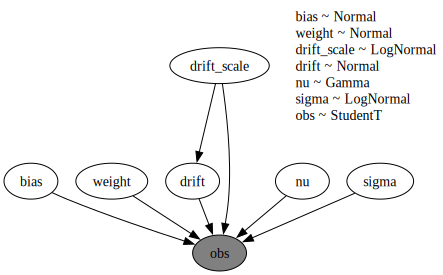

In [15]:
numpyro.render_model(
    model=model,
    model_kwargs={
        "y": data_train,
        "covariates": covariates_train,
    },
    render_distributions=True,
    render_params=True,
)

drift_scale shape: ()
pred_levels shape: (417, 1)
(417, 1)
mu shape: (417, 1)
drift_scale shape: ()
pred_levels shape: (417, 1)
(417, 1)
mu shape: (417, 1)
drift_scale shape: ()
pred_levels shape: (417, 1)
(417, 1)
mu shape: (417, 1)


  0%|          | 0/80000 [00:00<?, ?it/s]

drift_scale shape: ()
pred_levels shape: (417, 1)
(417, 1)
mu shape: (417, 1)


100%|██████████| 80000/80000 [00:14<00:00, 5370.72it/s, init loss: 6991.2954, avg. loss [76001-80000]: -111.0485]


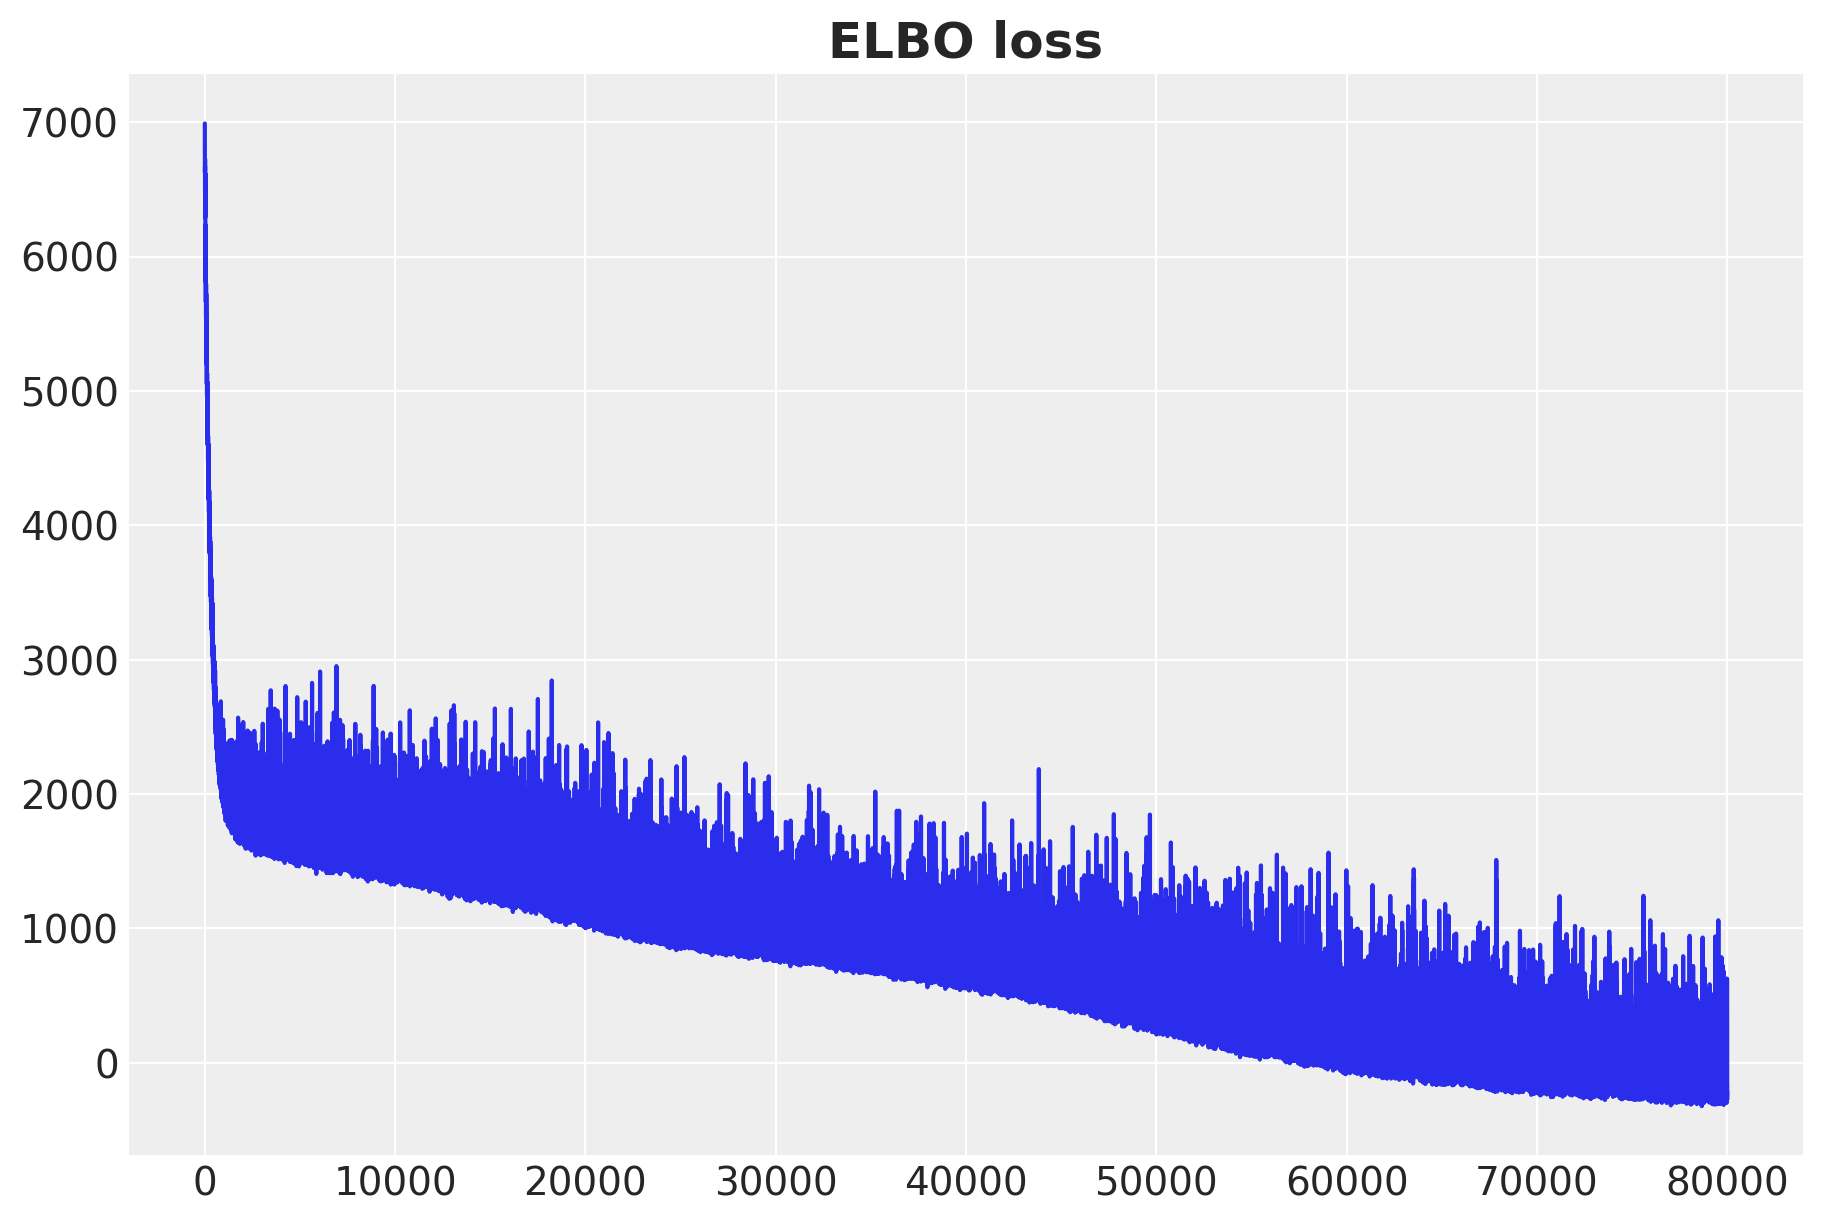

In [16]:
guide = AutoNormal(model)
optimizer = numpyro.optim.Adam(step_size=0.002)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
num_steps = 80_000

rng_key, rng_subkey = random.split(key=rng_key)

svi_result = svi.run(
    rng_subkey,
    num_steps,
    covariates_train,
    data_train,
)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set_title("ELBO loss", fontsize=18, fontweight="bold");

In [17]:
svi_posterior_predictive = Predictive(
    model=model,
    guide=guide,
    params=svi_result.params,
    num_samples=4_000,
)

In [18]:
rng_key, rng_subkey = random.split(rng_key)

idata_train = az.from_dict(
    posterior_predictive={
        k: v.transpose(2, 0, 1)
        for k, v in svi_posterior_predictive(rng_subkey, covariates_train).items()
    },
    # coords={"time_train": time_train.flatten()},
    # dims={"obs": ["time_train"]},
)

idata_test = az.from_dict(
    posterior_predictive={
        k: v.transpose(2, 0, 1)
        for k, v in svi_posterior_predictive(
            rng_subkey,
            covariates,
        ).items()
    },
    # coords={"time_test": time_test.flatten()},
    # dims={"obs": ["time_test"]},
)

drift_scale shape: ()
pred_levels shape: (417, 1)
(417, 1)
mu shape: (417, 1)
drift_scale shape: ()
pred_levels shape: (469, 1)
(469, 1)
mu shape: (469, 1)


In [19]:
idata_train

Inference data with groups:
	> posterior_predictive

In [20]:
def crps(truth, pred, sample_weight=None):
    if pred.shape[1:] != (1,) * (pred.ndim - truth.ndim - 1) + truth.shape:
        raise ValueError(
            f"""Expected pred to have one extra sample dim on left.
            Actual shapes: {pred.shape} versus {truth.shape}"""
        )

    absolute_error = jnp.mean(jnp.abs(pred - truth), axis=0)

    num_samples = pred.shape[0]
    if num_samples == 1:
        return jnp.average(absolute_error, weights=sample_weight)

    pred = jnp.sort(pred, axis=0)
    diff = pred[1:] - pred[:-1]
    weight = jnp.arange(1, num_samples) * jnp.arange(num_samples - 1, 0, -1)
    weight = weight.reshape(weight.shape + (1,) * (diff.ndim - 1))

    per_obs_crps = absolute_error - jnp.sum(diff * weight, axis=0) / num_samples**2
    return jnp.average(per_obs_crps, weights=sample_weight)


crps_train = crps(
    data_train,
    idata_train["posterior_predictive"]["obs"]
    .transpose(..., "obs_dim_0", "chain")
    .to_numpy(),
)

crps_test = crps(
    data_test,
    idata_test["posterior_predictive"]["obs"][:, :, T1:T2]
    .transpose(..., "obs_dim_0", "chain")
    .to_numpy(),
)

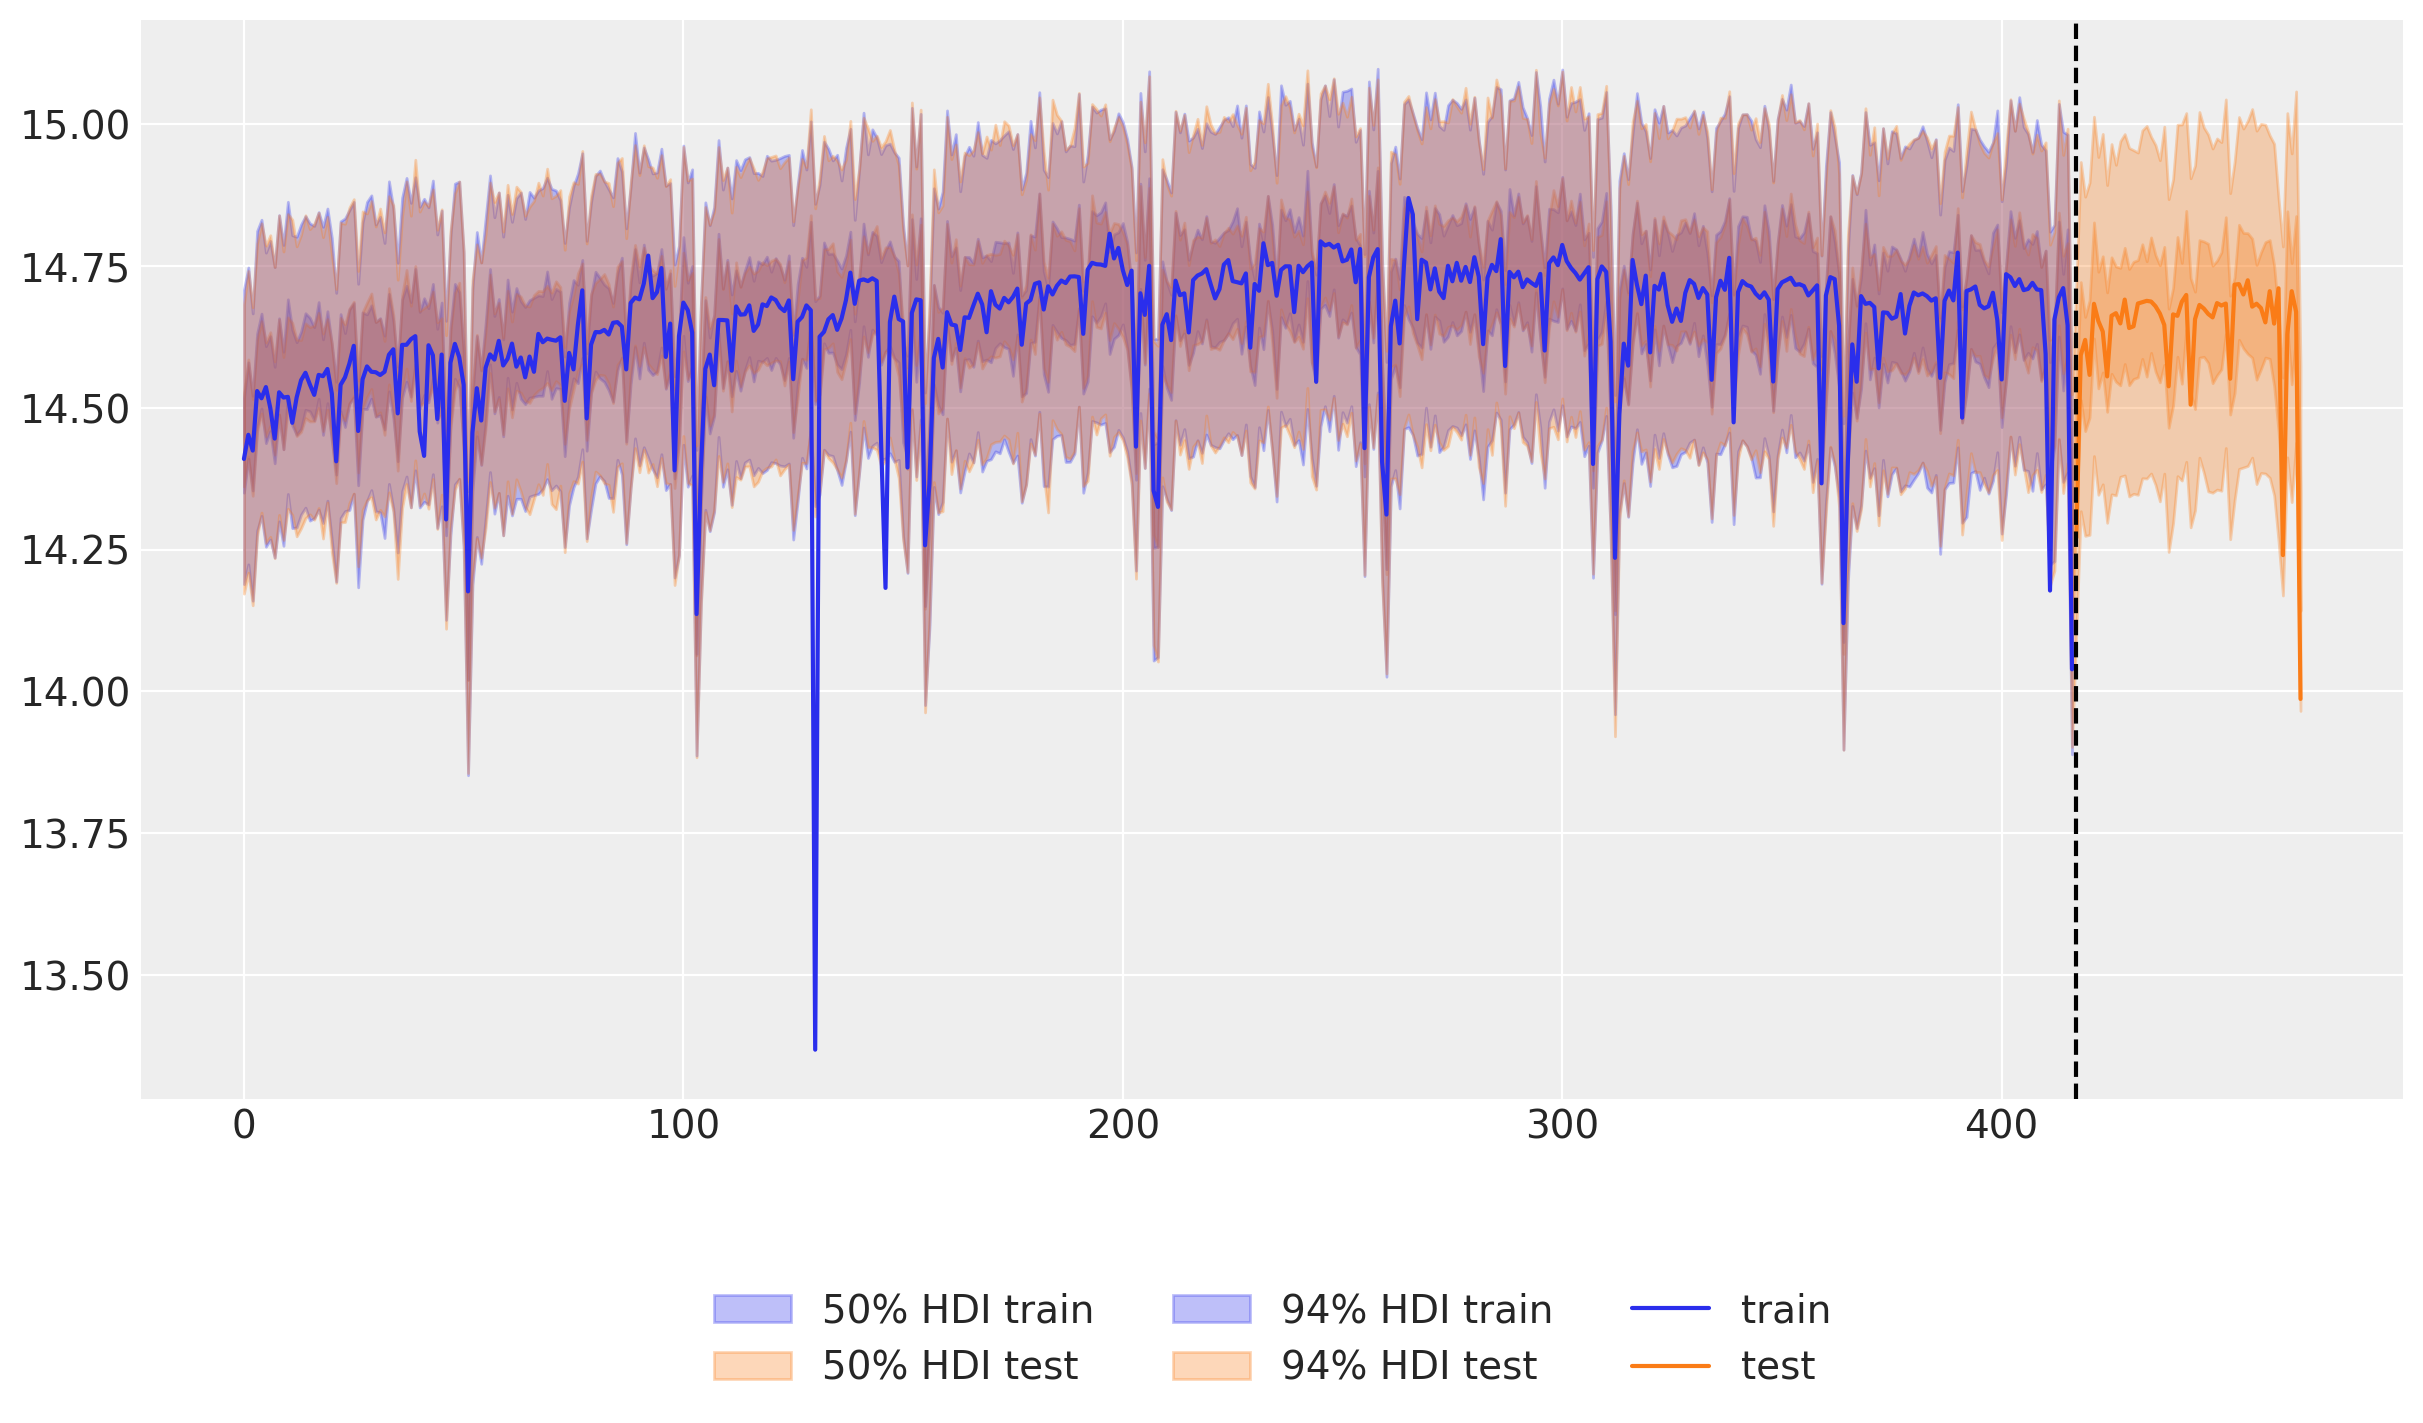

In [21]:
fig, ax = plt.subplots()

for hdi_prob in [0.50, 0.94]:
    az.plot_hdi(
        jnp.arange(T1),
        idata_train["posterior_predictive"]["obs"],
        hdi_prob=hdi_prob,
        color="C0",
        fill_kwargs={
            "alpha": 0.3,
            "label": f"{hdi_prob*100:.0f}% HDI train",
        },
        smooth=False,
        ax=ax,
    )
    az.plot_hdi(
        jnp.arange(0, T2),
        idata_test["posterior_predictive"]["obs"],
        hdi_prob=hdi_prob,
        color="C1",
        fill_kwargs={
            "alpha": 0.3,
            "label": f"{hdi_prob*100:.0f}% HDI test",
        },
        smooth=False,
        ax=ax,
    )

ax.plot(jnp.arange(T1), data_train, label="train")
ax.plot(jnp.arange(T1, T2), data_test, label="test")
ax.axvline(T1, c="black", linestyle="--")
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=3)
# ax.set(
#     title=f"Train CRPS: {crps_train:.4f} | Test CRPS: {crps_test:.4f}",
#     ylabel="log(# rides)",
#     xlabel="Week after 2011-01-01",
# )
# fig.suptitle("Total weekly ridership", fontsize=18, fontweight="bold");

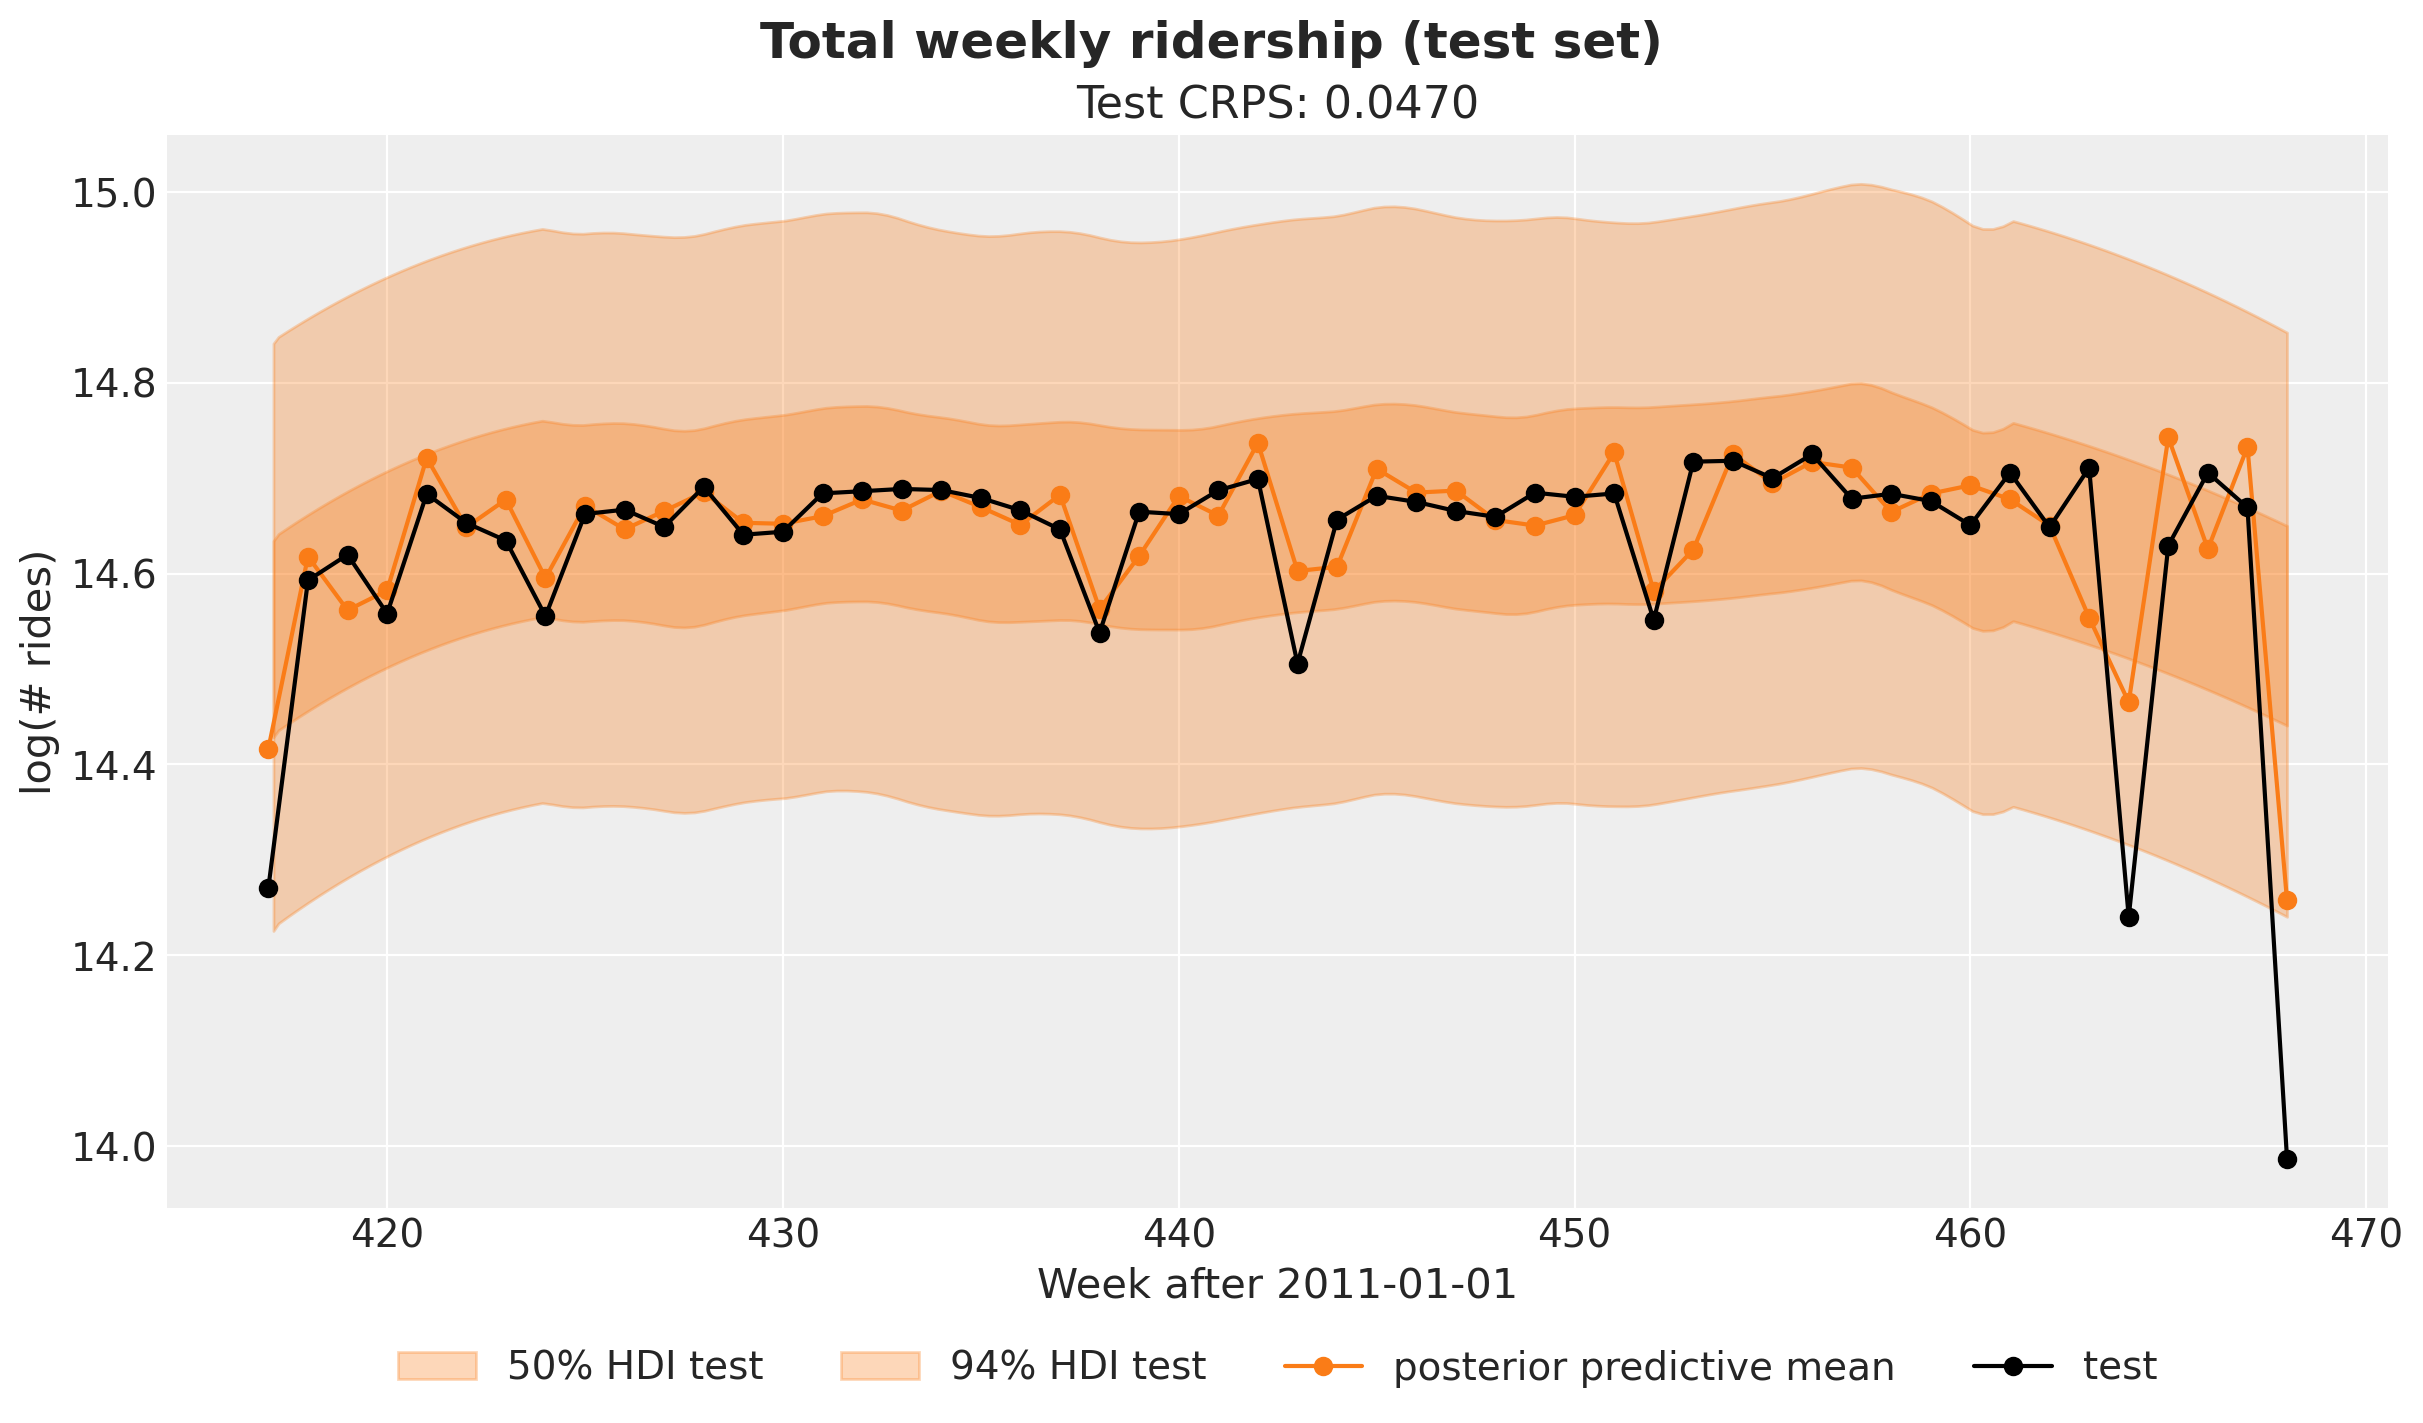

In [22]:
fig, ax = plt.subplots()

for hdi_prob in [0.50, 0.94]:
    az.plot_hdi(
        jnp.arange(T1, T2),
        idata_test["posterior_predictive"]["obs"][:, :, T1:T2],
        hdi_prob=hdi_prob,
        color="C1",
        fill_kwargs={
            "alpha": 0.3,
            "label": f"{hdi_prob*100:.0f}% HDI test",
        },
        ax=ax,
    )

ax.plot(
    jnp.arange(T1, T2),
    idata_test["posterior_predictive"]["obs"][:, :, T1:T2].mean(dim=("chain", "draw")),
    marker="o",
    color="C1",
    label="posterior predictive mean",
)
ax.plot(jnp.arange(T1, T2), data_test, marker="o", color="black", label="test")
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=4)
ax.set(
    title=f"Test CRPS: {crps_test:.4f}",
    ylabel="log(# rides)",
    xlabel="Week after 2011-01-01",
)
fig.suptitle("Total weekly ridership (test set)", fontsize=18, fontweight="bold");